# **Project Name**    -  Integrated retail analytics



##### **Project Type**    - Regression
##### **Contribution**    - Individual
##### **Author**          - Aparna Praturi


# **Project Summary -**

# **GitHub Link -**

# **Problem Statement**


# **Part-I. Data Preparation and EDA**

## ***1. Knowing Data***

### 1.1. Importing Libraries

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import sys

In [5]:
!{sys.executable} -m pip install xgboost optuna prophet


In [6]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import warnings
from tqdm import tqdm
import optuna
import json
import joblib

### 1.2 Loading Data

In [ ]:
# Loading data

SCRIPT_DIR= Path().resolve().parent

cleaned_data_path = SCRIPT_DIR/'data'/'processed'/'cleaned_data.csv'

try:
  df_merged = pd.read_csv(f'{cleaned_data_path}')
  print(f"Data loaded into successfully!")

except FileNotFoundError:
    print(f"Error: The file(s)  were not found. Please check the path.")

Data loaded into successfully!


## Demand Forecasting

In [ ]:
df_forecast = df_merged.copy()


### Forecast using Prophet

In [ ]:
# Tuned Prophet Forecast (Chain/Store)

def prophet_forecast_tuned(df, horizon=20, n_trials=50, level="Chain", store=None):
    df = df[['Store','Date','Weekly_Sales_cleaned']].copy()

    if level == "Chain":
        data = df.copy()
    elif level == "Store":
        data = df[df['Store']==store].copy()
    else:
        return None

    data['Date'] = pd.to_datetime(data['Date'])
    agg = data.groupby('Date')['Weekly_Sales'].sum().reset_index()
    agg.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'}, inplace=True)
    agg = agg.sort_values('ds')

    if len(agg) < horizon * 2:
        return None

    train_size = int(len(agg) * 0.8)
    train, test = agg.iloc[:train_size], agg.iloc[train_size:]

    def objective(trial):
        params = {
            "changepoint_prior_scale": trial.suggest_float("changepoint_prior_scale", 0.001, 0.5, log=True),
            "seasonality_prior_scale": trial.suggest_float("seasonality_prior_scale", 0.01, 10.0, log=True),
            "seasonality_mode": trial.suggest_categorical("seasonality_mode", ["additive", "multiplicative"]),
            "n_changepoints": trial.suggest_int("n_changepoints", 5, 50),
        }
        m = Prophet(
            weekly_seasonality=True,
            yearly_seasonality=True,
            **params
        )
        m.fit(train)
        future = m.make_future_dataframe(periods=len(test), freq='W')
        forecast = m.predict(future)
        preds = forecast.iloc[-len(test):]['yhat'].values
        return r2_score(test['y'].values, preds)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False,n_jobs=-1)
    best_params = study.best_params

    # Final model
    m_best = Prophet(weekly_seasonality=True, yearly_seasonality=True, **best_params)
    m_best.fit(train)
    future = m_best.make_future_dataframe(periods=len(test), freq='W')
    forecast = m_best.predict(future)

    preds = forecast.iloc[-len(test):]['yhat'].values
    y_true = test['y'].values
    rmse = np.sqrt(mean_squared_error(y_true, preds))
    r2 = r2_score(y_true, preds)


    print(f"Level: {level} | Store: {store} | Model: Prophet (Tuned) | RMSE: {rmse:.2f} | R2: {r2:.3f} | Trained_model: {m_best}")
    plt.figure(figsize=(12,6))
    plt.plot(train['ds'], train['y'], label="Training Data", color="blue")
    plt.plot(test['ds'], y_true, label="Actual Test Data", color="green")
    plt.plot(test['ds'], preds, label="Prophet Forecast", color="red", linestyle="--")
    
    plt.title("Prophet Forecast vs Actuals")
    plt.xlabel("Date")
    plt.ylabel("Weekly Sales")
    plt.legend()
    plt.show()
    return

In [13]:
def prophet_forecast_tuned(df, horizon=20, n_trials=50, level="Chain", store=None):

    RESULTS_DIR = SCRIPT_DIR/'results' 
    RESULTS_DIR.mkdir(parents=True, exist_ok=True) 
    df = df[['Store','Date','Weekly_Sales']].copy()

    if level == "Chain":
        data = df.copy()
    elif level == "Store":
        data = df[df['Store']==store].copy()
    else:
        return None    

    agg = data.groupby('Date')['Weekly_Sales'].sum().reset_index()
    agg.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'}, inplace=True)
    agg['ds'] = pd.to_datetime(agg['ds'])
    agg = agg.set_index('ds').asfreq('W-FRI').rename_axis('ds').reset_index().sort_values('ds')

    # log transform
    agg['y'] = np.log1p(agg['y'])

    train_size = int(len(agg) * 0.8)
    train, test = agg.iloc[:train_size].copy(), agg.iloc[train_size:].copy()

    def objective(trial):
        params = {
        "changepoint_prior_scale": trial.suggest_float("changepoint_prior_scale", 0.001, 0.5, log=True),
        "seasonality_prior_scale": trial.suggest_float("seasonality_prior_scale", 0.01, 10.0, log=True),
        "seasonality_mode": trial.suggest_categorical("seasonality_mode", ["additive", "multiplicative"]),
        "n_changepoints": trial.suggest_int("n_changepoints", 5, 50),
        }
        m = Prophet(weekly_seasonality=True, yearly_seasonality=True, **params)
        m.add_country_holidays('US')  
        m.fit(train)
        future = m.make_future_dataframe(periods=len(test), freq='W-FRI')
        forecast = m.predict(future)
        preds = forecast.iloc[-len(test):]['yhat'].values
        # invert log
        preds = np.expm1(preds); y_true = np.expm1(test['y'].values)
        return r2_score(y_true, preds)
        
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False,n_jobs=-1)
    best_params = study.best_params

    #tuning
    m_best = Prophet(weekly_seasonality=True, yearly_seasonality=True, **best_params)
    m_best.add_country_holidays('US')
    m_best.fit(train)
    future = m_best.make_future_dataframe(periods=len(test), freq='W-FRI')
    forecast = m_best.predict(future)
    preds = np.expm1(forecast.iloc[-len(test):]['yhat'].values)
    y_true = np.expm1(test['y'].values)

    rmse = np.sqrt(mean_squared_error(y_true, preds))
    r2 = r2_score(y_true, preds)

    print(f"Level: {level} | Store: {store} | Model: Prophet (Tuned) | RMSE: {rmse:.2f} | R2: {r2:.3f} | Trained_model: {m_best}")
    

    plt.figure(figsize=(12,6))
    plt.plot(train['ds'], np.expm1(train['y']), label="Training")
    plt.plot(test['ds'], y_true, label="Actual Test")
    plt.plot(test['ds'], preds, label="Prophet Forecast", linestyle="--")
    plt.title(f"Prophet Forecast vs Actuals ({level} - {store})")
    plt.xlabel("Date"); plt.ylabel("Weekly Sales"); plt.legend(); plt.tight_layout()

    PLOT_FILENAME = f'Longterm forecasting usingProphet for store {store}.png'
    PLOT_SAVE_PATH = RESULTS_DIR / PLOT_FILENAME 
    plt.savefig(PLOT_SAVE_PATH)
    print(f"Plot saved successfully to: {PLOT_SAVE_PATH}")
    plt.show()

    return


[I 2025-10-04 10:41:55,136] A new study created in memory with name: no-name-796cd6ec-a493-493c-906e-9e29b8352a50
10:41:55 - cmdstanpy - INFO - Chain [1] start processing
10:41:55 - cmdstanpy - INFO - Chain [1] start processing
10:41:55 - cmdstanpy - INFO - Chain [1] start processing
10:41:55 - cmdstanpy - INFO - Chain [1] start processing
10:41:55 - cmdstanpy - INFO - Chain [1] start processing
10:41:55 - cmdstanpy - INFO - Chain [1] start processing
10:41:55 - cmdstanpy - INFO - Chain [1] start processing
10:41:55 - cmdstanpy - INFO - Chain [1] start processing
10:41:56 - cmdstanpy - INFO - Chain [1] done processing
10:41:56 - cmdstanpy - INFO - Chain [1] done processing
10:41:56 - cmdstanpy - INFO - Chain [1] done processing
10:41:56 - cmdstanpy - INFO - Chain [1] done processing
10:41:56 - cmdstanpy - INFO - Chain [1] done processing
10:41:56 - cmdstanpy - INFO - Chain [1] done processing
10:41:56 - cmdstanpy - INFO - Chain [1] done processing
10:41:56 - cmdstanpy - INFO - Chain [1

Level: Store | Store: 10 | Model: Prophet (Tuned) | RMSE: 54250.60 | R2: 0.511 | Trained_model: <prophet.forecaster.Prophet object at 0x0000021F34F740D0>
Plot saved successfully to: C:\Users\aparn\OneDrive\Desktop\AB\Advanced ML\Retail Analytics\results\Longterm forecasting usingProphet for store 10.png


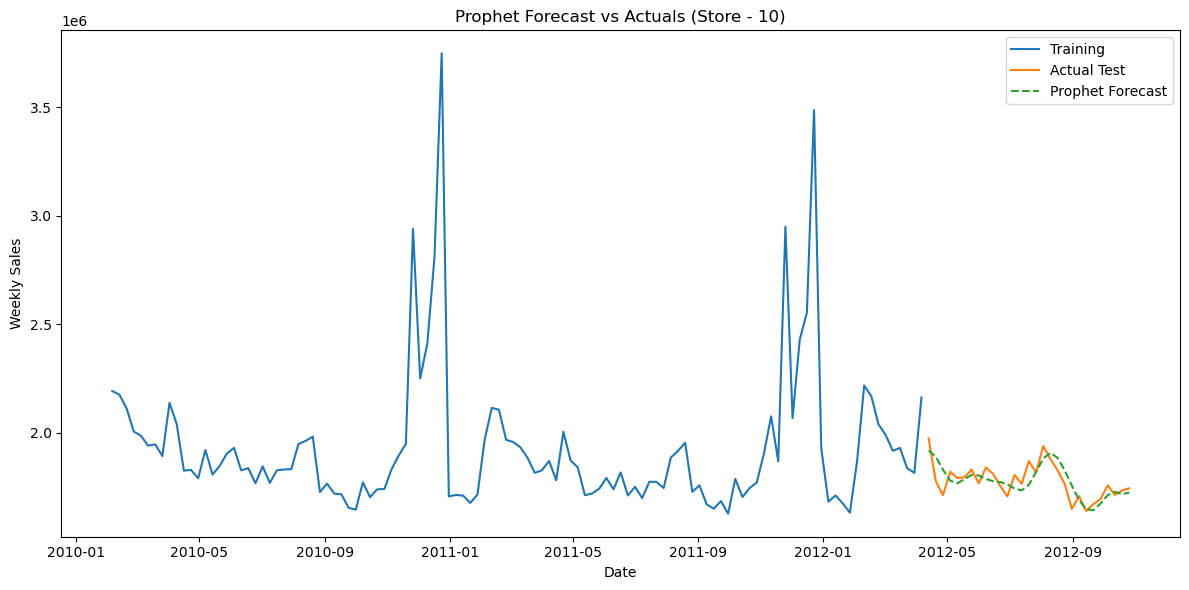

In [14]:
horizon_long=20

# for stor in df_forecast['Store'].unique():
#     prophet_forecast_tuned(df_forecast, horizon=horizon_long, level="Store", store=stor)
        
prophet_forecast_tuned(df_forecast, horizon=horizon_long, level="Store", store=10)

### Forecasting using XGBoost

In [17]:

# Walk-forward validation for XGBoost

def walk_forward_validation(X, y, params, use_log=True, horizon=20):
    n_total = len(y)
    window_size = int(n_total * 0.7)
    rmse_scores = []
    r2_scores = []
    for start in range(window_size, n_total - horizon, horizon):
        X_train, y_train = X.iloc[:start], y.iloc[:start]
        X_val, y_val = X.iloc[start:start+horizon], y.iloc[start:start+horizon]
        y_train_model = np.log1p(y_train) if use_log else y_train
        model = XGBRegressor(**params)
        model.fit(X_train, y_train_model, verbose=False)
        y_pred = model.predict(X_val)
        if use_log:
            y_pred = np.expm1(y_pred)
        rmse_scores.append(np.sqrt(mean_squared_error(y_val, y_pred)))
        r2_scores.append(r2_score(y_val, y_pred))
    return float(np.mean(r2_scores)), float(np.mean(rmse_scores))




In [ ]:

# Tuned XGBoost Forecast 

def xgb_forecast_tuned(df, horizon=20, n_trials=30, level="Chain", store=None):


    RESULTS_DIR = SCRIPT_DIR/'results' 
    RESULTS_DIR.mkdir(parents=True, exist_ok=True) 
    
    df = df[['Store','Date','Weekly_Sales']].copy()

    if level == 'Chain':
        group = df.copy()
    elif level == 'Store':
        group = df[df['Store']==store].copy()
    else:
        return None
    
    # creating rolling and lag features

    group["date"] = pd.to_datetime(group["Date"])
    group = group.groupby("date")["Weekly_Sales"].sum().reset_index().sort_values("date")
    group = group.set_index("date")

    
    group["lag_1"] = group["Weekly_Sales"].shift(1)
    group["lag_2"] = group["Weekly_Sales"].shift(2)
    group["lag_52"] = group["Weekly_Sales"].shift(52)
    for w in [4,12,52]:
        group[f"roll_mean_{w}"] = group["Weekly_Sales"].shift(1).rolling(w).mean()
    group["weekofyear"] = group.index.isocalendar().week.astype(int)
    group["month"] = group.index.month
    group["year"] = group.index.year

    group = group.dropna()
    
    X = group.drop(columns=["Weekly_Sales"])
    y = group["Weekly_Sales"]

    # Optuna objective
    def objective(trial):
        params = {
            "objective": "reg:squarederror",
            "n_estimators": trial.suggest_int("n_estimators", 200, 800),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
            "random_state": 42
        }
        use_log = trial.suggest_categorical("use_log", [True, False])
        mean_r2, _ = walk_forward_validation(X, y, params, use_log=use_log, horizon=horizon)
        return mean_r2
    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, n_jobs=1)
    best_params = study.best_params
    use_log = best_params.pop("use_log")

    # Final evaluation
    train_size = int(len(X)*0.8)
    train, test = group.iloc[:train_size], group.iloc[train_size:]
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
    y_train_final = np.log1p(y_train) if use_log else y_train

    model = XGBRegressor(**best_params)
    model.fit(X_train, y_train_final)
    y_pred = model.predict(X_test)
    if use_log:
        y_pred = np.expm1(y_pred)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"Level: {level} | Store: {store} | Model: Prophet (Tuned) | RMSE: {rmse:.2f} | R2: {r2:.3f} | Trained_model: {model}")

    plt.figure(figsize=(12,6))
    plt.plot(train.index, y_train, label="Training Data", color="blue")
    plt.plot(test.index, y_test, label="Actual Test Data", color="green")
    plt.plot(test.index, y_pred, label="XGBoost Forecast", color="red", linestyle="--")
   
    plt.title("XGBoost Forecast vs Actuals")
    plt.xlabel("Date")
    plt.ylabel("Weekly Sales")
    plt.legend()
    PLOT_FILENAME = f'Longterm forecasting using XGBoost for store {store}.png'
    PLOT_SAVE_PATH = RESULTS_DIR / PLOT_FILENAME 
    plt.savefig(PLOT_SAVE_PATH)
    print(f"Plot saved successfully to: {PLOT_SAVE_PATH}")
    plt.show()

[I 2025-10-04 11:05:02,105] A new study created in memory with name: no-name-5f474563-b48c-4e86-9c10-8627205d1269
[I 2025-10-04 11:05:02,208] Trial 0 finished with value: -2.5098015378786935 and parameters: {'n_estimators': 782, 'max_depth': 5, 'learning_rate': 0.014231889419349277, 'subsample': 0.9002260743051951, 'colsample_bytree': 0.7362369828882768, 'min_child_weight': 4, 'gamma': 0.7399497760210421, 'reg_lambda': 2.0455247296090873, 'reg_alpha': 0.8043480507022532, 'use_log': True}. Best is trial 0 with value: -2.5098015378786935.
[I 2025-10-04 11:05:02,504] Trial 1 finished with value: -2.094744517225007 and parameters: {'n_estimators': 781, 'max_depth': 10, 'learning_rate': 0.1540826846042588, 'subsample': 0.6994401258578173, 'colsample_bytree': 0.846498588330937, 'min_child_weight': 4, 'gamma': 0.5201291542045956, 'reg_lambda': 4.203341236484418, 'reg_alpha': 2.0835817647701145, 'use_log': False}. Best is trial 1 with value: -2.094744517225007.
[I 2025-10-04 11:05:02,559] Tria

Level: Store | Store: 10 | Model: Prophet (Tuned) | RMSE: 54806.50 | R2: 0.507 | Trained_model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9081079447502541, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=1.3968654596666663, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.010615938049402675,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=225, n_jobs=None,
             num_parallel_tree=None, ...)
Plot saved successfully to: C:\Users\aparn\OneDrive\Desktop\AB\Advanced ML\Retail Analytics\results\Long

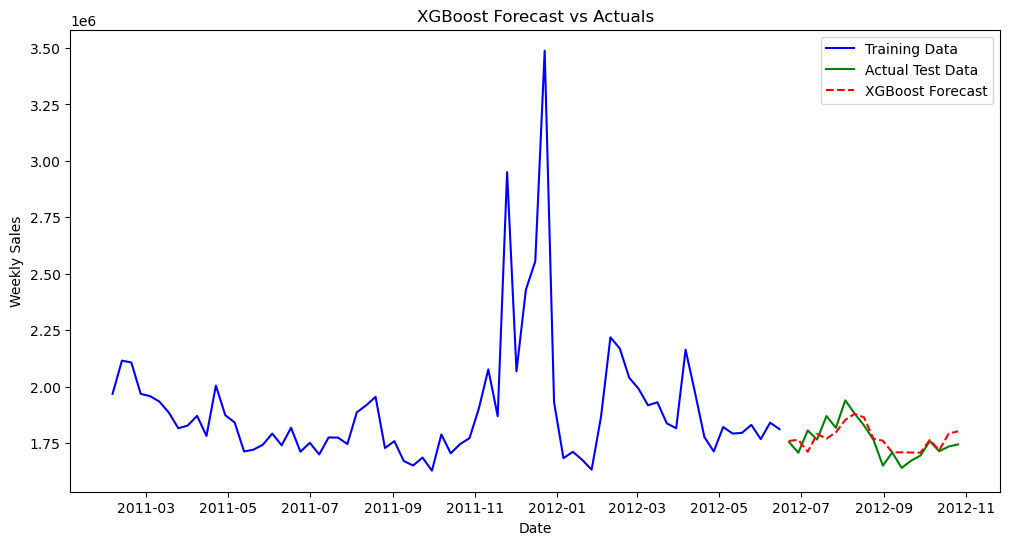

In [38]:
horizon_long=20

# for stor in df_forecast['Store'].unique():
#     prophet_forecast_tuned(df_forecast, horizon=horizon_long, level="Store", store=stor)
        
xgb_forecast_tuned(df_forecast, horizon=horizon_long, level="Store", store=10)